# Q-learning

In this notebook, you will implement Q-learning as described in [Sutton and Barto's book, Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html). We will use the grid ```World``` class from the previous lectures.

### Install dependencies

In [37]:
! pip install numpy pandas
! pip install numpy matplotlib

### Imports

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sys          # We use sys to get the max value of a float
import pandas as pd # We only use pandas for displaying tables nicely
pd.options.display.float_format = '{:,.3f}'.format

### ```World``` class and globals

The ```World``` is a grid represented as a two-dimensional array of characters where each character can represent free space, an obstacle, or a terminal. Each non-obstacle cell is associated with a reward that an agent gets for moving to that cell (can be 0). The size of the world is _width_ $\times$ _height_ characters.

A _state_ is a tuple $(x,y)$.

An empty world is created in the ```__init__``` method. Obstacles, rewards and terminals can then be added with ```add_obstacle``` and ```add_reward```.

To calculate the next state of an agent (that is, an agent is in some state $s = (x,y)$ and performs and action, $a$), ```get_next_state()```should be called.

In [3]:
# Globals:
ACTIONS = ("up", "down", "left", "right")

# Rewards, terminals and obstacles are characters:
REWARDS = {" ": -1, ".": 0.1, "+": 10, "-": -100}
TERMINALS = ("+", "-") # Note a terminal should also have a reward assigned
OBSTACLES = ("#")

# Discount factor
gamma = 1

# The probability of a random move:
rand_move_probability = 0

class World:
  def __init__(self, width, height):
    self.width = width
    self.height = height
    # Create an empty world where the agent can move to all cells
    self.grid = np.full((width, height), ' ', dtype='U1')

  def add_obstacle(self, start_x, start_y, end_x=None, end_y=None):
    """
    Create an obstacle in either a single cell or rectangle.
    """
    if end_x == None: end_x = start_x
    if end_y == None: end_y = start_y

    self.grid[start_x:end_x + 1, start_y:end_y + 1] = OBSTACLES[0]

  def add_reward(self, x, y, reward):
    assert reward in REWARDS, f"{reward} not in {REWARDS}"
    self.grid[x, y] = reward

  def add_terminal(self, x, y, terminal):
    assert terminal in TERMINALS, f"{terminal} not in {TERMINALS}"
    self.grid[x, y] = terminal

  def is_obstacle(self, x, y):
    if x < 0 or x >= self.width or y < 0 or y >= self.height:
      return True
    else:
      return self.grid[x ,y] in OBSTACLES

  def is_terminal(self, x, y):
    return self.grid[x ,y] in TERMINALS

  def get_reward(self, x, y):
    """
    Return the reward associated with a given location
    """
    return REWARDS[self.grid[x, y]]

  def get_next_state(self, current_state, action):
    """
    Get the next state given a current state and an action. The outcome can be
    stochastic  where rand_move_probability determines the probability of
    ignoring the action and performing a random move.
    """
    assert action in ACTIONS, f"Unknown acion {action} must be one of {ACTIONS}"

    x, y = current_state

    # If our current state is a terminal, there is no next state
    if self.grid[x, y] in TERMINALS:
      return None

    # Check of a random action should be performed:
    if np.random.rand() < rand_move_probability:
      action = np.random.choice(ACTIONS)

    if action == "up":      y -= 1
    elif action == "down":  y += 1
    elif action == "left":  x -= 1
    elif action == "right": x += 1

    # If the next state is an obstacle, stay in the current state
    return (x, y) if not self.is_obstacle(x, y) else current_state


## A simple world

In [4]:
world = World(4, 6)

# Since we only focus on episodic tasks, we must have a terminal state that the
# agent eventually reaches
world.add_terminal(3, 5, "+")

print(world.grid.T)

[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '+']]


## Exercise: Q-learning

Implement and test Q-learning. You should be able to base much of your code on your implementation of SARSA. Since Q-learning is an off-policy method, we can use whatever behavior policy we want during training, but the choice of behavioral policy still manners so it is a good idea to balance exploration and exploitation. During testing, we can then use the learnt policy (the target policy).

As for the behavior policy, you can use an simple $\epsilon$-greedy policy, but you can also experiment with alternatives, for instance, optimistic initial values.

See page 131 in [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html) for the Q-learning algorithm.


In [46]:
# TODO: Implement your code here -- you need a Q-table to keep track of action
#       value estimates and a policy-function that returns an epsilon greedy
#       policy based on your estimates.
world2 = World(4,4)
world2.add_terminal(3, 3, "+")
EPISODES = 10000
epsilon = 0.1
alpha = 0.1

def epsilon_greedy(state, Q):
  x,y = state
  if np.random.rand() <= epsilon:
    return random.choice(ACTIONS)
  else:
    return ACTIONS[np.argmax(Q[x,y])]

rewards = []

def q_learning(world, start_state):
  Q = np.random.rand(world.width, world.height,len(ACTIONS))
  for episode in range(EPISODES):
    current_state = start_state
    current_action = epsilon_greedy(current_state, Q)

    action_to_index = {action: i for i, action in enumerate(ACTIONS)}

    total_reward = 0

    while not world.is_terminal(current_state[0], current_state[1]):

      # Get the next state from the world
      next_state = world.get_next_state(current_state, current_action)
      next_action = epsilon_greedy(next_state, Q)
      best_action = ACTIONS[np.argmax(Q[next_state[0], next_state[1]])]

      Q[current_state[0], current_state[1], action_to_index[current_action]] += alpha * (
          world.get_reward(*next_state) + gamma * Q[next_state[0], next_state[1], action_to_index[best_action]]
        - Q[current_state[0], current_state[1], action_to_index[current_action]])
      
      total_reward += world.get_reward(*next_state)

      current_state = next_state
      current_action = next_action
    rewards.append(total_reward)

  return Q

Q_q = q_learning(world2, (0, 0))

Pol = np.full((world2.width, world2.height),"     ")

for x in range(world2.width):
  for y in range(world2.height):
    for action in ACTIONS:
      Pol[x,y] = ACTIONS[np.argmax(Q_q[x,y])]

Pol[3,3] = "GOAL"
#display(pd.DataFrame(world2.grid.T))
display(pd.DataFrame(Pol.T))

,0,1,2,3
0,down,down,down,down
1,down,down,down,down
2,right,right,down,down
3,right,right,right,GOAL


## Exercise: Compare Q-learning and SARSA

Setup experiments to compare the performance of Q-learning and SARSA. You can use different ```Worlds``` and test different parameter setting, e.g. for $\alpha$ and $\epsilon$.

,0,1,2,3,4
0,right,right,down,down,down
1,right,right,right,right,GOAL
2,right,right,down,down,left
3,right,right,right,GOAL,left
4,down,right,up,up,up


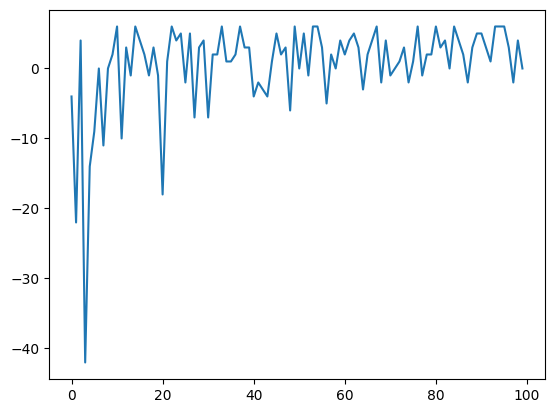

In [ ]:
### TODO: Implement your code here
# cliffWorld = World(12,4)
# cliffWorld.add_terminal(11, 3, "+")
# cliffWorld.add_terminal(1, 3, "-")
# cliffWorld.add_terminal(2, 3, "-")
# cliffWorld.add_terminal(3, 3, "-")
# cliffWorld.add_terminal(4, 3, "-")
# cliffWorld.add_terminal(5, 3, "-")
# cliffWorld.add_terminal(6, 3, "-")
# cliffWorld.add_terminal(7, 3, "-")
# cliffWorld.add_terminal(8, 3, "-")
# cliffWorld.add_terminal(9, 3, "-")
# cliffWorld.add_terminal(10, 3, "-")

# pol_q = np.full((cliffWorld.width, cliffWorld.height),"     ")
# pol_s = np.full((cliffWorld.width, cliffWorld.height),"     ")



def sarsa(world, start_state):
  Q = np.zeros((world.width, world.height,len(ACTIONS)))
  for episode in range(EPISODES):
    current_state = start_state
    current_action = epsilon_greedy(current_state, Q)

    action_to_index = {action: i for i, action in enumerate(ACTIONS)}

    while not world.is_terminal(current_state[0], current_state[1]):

      # Get the next state from the world
      next_state = world.get_next_state(current_state, current_action)
      next_action = epsilon_greedy(next_state, Q)

      Q[current_state[0], current_state[1], action_to_index[current_action]] += alpha * (
          world.get_reward(*next_state) + gamma *
          Q[next_state[0], next_state[1], action_to_index[next_action]] -
          Q[current_state[0], current_state[1], action_to_index[current_action]])
      current_state = next_state
      current_action = next_action
  return Q

# EPISODES = 5000
# epsilon = 0.01

# Q_s = sarsa(cliffWorld, (0,3))
# Q_q = q_learning(cliffWorld, (0, 3))



# for x in range(cliffWorld.width):
#   for y in range(cliffWorld.height):
#     for action in ACTIONS:
#       pol_q[x,y] = ACTIONS[np.argmax(Q_q[x,y])]
#       pol_s[x,y] = ACTIONS[np.argmax(Q_s[x,y])]

# for i in range(1,11):
#   pol_s[i,3] = "CLIFF"
#   pol_q[i,3] = "CLIFF"

# pol_s[11,3] = "GOAL"
# pol_q[11,3] = "GOAL"
# print("Q-Learning")
# display(pd.DataFrame(pol_q.T))
# print("\n")
# print("SARSA")
# display(pd.DataFrame(pol_s.T))

worldy = World(5,5)
worldy.add_terminal(3, 3, "+")
worldy.add_terminal(4, 1, "+")

EPISODES = 100
epsilon = 0.5
alpha = 0.9
rewards = []

Q_q = q_learning(worldy, (0, 0))

Pol = np.full((worldy.width, worldy.height),None)

for x in range(worldy.width):
  for y in range(worldy.height):
    for action in ACTIONS:
      Pol[x,y] = ACTIONS[np.argmax(Q_q[x,y])]

Pol[3,3] = "GOAL"
Pol[4,1] = "GOAL"
display(pd.DataFrame(Pol.T))
plt.plot(rewards)


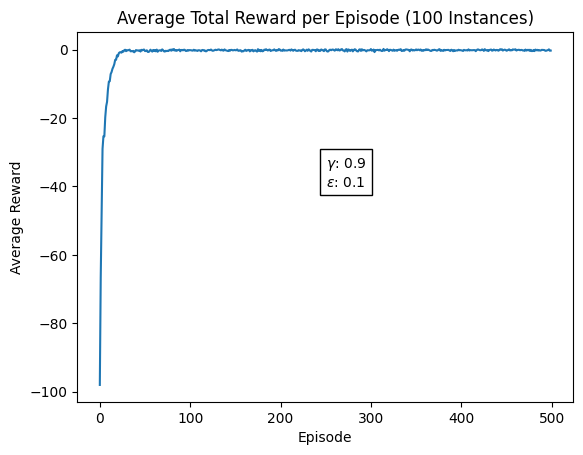

,0,1,2,3,4,5
0,right,down,down,right,right,up
1,down,down,down,down,right,up
2,right,right,down,down,down,down
3,right,right,down,down,right,down
4,up,right,right,right,down,down
5,up,down,up,right,right,GOAL


,0,1,2,3,4,5
0,,,,,,
1,,,,,,
2,,,,,,
3,,,,,,
4,,,,,,
5,,,,,,+


In [140]:
worldy = World(6,6)
worldy.add_terminal(5, 5, "+")
# worldy.add_terminal(4, 5, "+")

EPISODES = 500
epsilon = 0.1
alpha = 0.9
gamma = 0.9
INSTANCES = 100

# Array til at akkumulere rewards fra hver instance
rewards_all_instances = np.zeros(EPISODES)

for instance in range(INSTANCES):
    # print(f"Running instance {instance + 1}/{INSTANCES}...")

    # Initialiser Q-learning for denne instance
    rewards = []  # Reset rewards for denne instance
    Q_q = q_learning(worldy, (0, 0))

    # Akkumulér rewards for hver episode
    rewards_all_instances += np.array(rewards)  # Summér rewards på tværs af instances

# Beregn gennemsnittet over alle instances
average_rewards = rewards_all_instances / INSTANCES

# Plot gennemsnittet
plt.plot(average_rewards)
plt.title("Average Total Reward per Episode (100 Instances)")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
params_text = f"$\\gamma$: {gamma}\n$\\epsilon$: {epsilon}"
plt.text(0.5 * EPISODES, -40, params_text, fontsize=10,
         bbox=dict(facecolor='white', edgecolor='black'))
plt.show()

# Valgfrit: Vis den politik, som den lærte i den sidste instance
Pol = np.full((worldy.width, worldy.height), None)
for x in range(worldy.width):
    for y in range(worldy.height):
        if not worldy.is_terminal(x, y):
            Pol[x, y] = ACTIONS[np.argmax(Q_q[x, y])]
Pol[5, 5] = "GOAL"
# Pol[4, 1] = "GOAL"
display(pd.DataFrame(Pol.T))
display(pd.DataFrame(worldy.grid.T))

## Optional exercise: Maximization Bias and Double Learning

Below is an implementation of the task shown in Example 6.7 on page 134 in [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html). There are two states, ```A``` and ```B``` where the agent can perform actions, and a terminal state ```T```. ```A``` and ```B``` have different actions available:

* ```A``` has ```left``` (to ```B```) and ```right``` to the terminal state
* ```B``` has a larger number of actions all leading to a terminal state.


In [7]:
# States "A" and "B" have actions while "T" is a terminal state.
STATES = ("A", "B", "T")

class Example67MDP:
    def __init__(self, number_of_B_actions):
        """
        Create an example and set the number of outgoing actions for state "B"
        (in the book, they do not give a specific number, but merely write that
        from "B" there "are many possible actions all of which cause immediate
        termination with a reward drawn from a normal distribution with mean
        -0.1 and variance 1. So, feel free to play with different number of
        actions in state B)

        """
        self.number_of_B_actions = number_of_B_actions

    def get_actions(self, state):
        """
        Returns the set of actions availabe in a given state (a tuple
        with strings).
        """
        assert state in STATES, f"State must be one of {STATES}, not {state}"
        if state == "A":
            return ("left", "right")
        if state == "B":
            return tuple(f"{i}" for i in range(self.number_of_B_actions))
        if state == "T":
            return tuple("N")

    def get_next_state_and_reward(self, state, action):
        """
        Get the next state and reward given a current state and an action
        """
        assert state in STATES, f"Unknown state: {state}"
        assert action in self.get_actions(state), f"Unknown action {action} for state {state}"

        if state == "T":
            raise Exception("The terminal state has no actions and no next state")

        if state == "A":
            if action == "right":
                return "T", 0
            if action == "left":
                return "B", 0

        if state == "B":
            return "T", np.random.normal(loc = -0.1)

    def is_terminal(self, state):
        assert state in STATES, f"Unknown state: {state}"
        return state == "T"


Implement Double Q-learning (see page 136 in [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html)) and test it on the ```Example67MDP``` above. Notice, that the number of actions differs between the two states ($\mathcal{A}$(```"A"```) $\neq \mathcal{A}$(```"B"```)), which you have to take into account in your Q-tables. See the code for ```Example67MDP``` above: you can get the set of actions available in a given state by calling ```get_actions(...)``` with the state as argument.

Compare action-value estimates for ```"left"``` and ```"right"``` in state ```"A"```  at different times during learning when using double-Q learning and when using normal Q-learning.

In [8]:
# Create an instance of Example 6.7 with 10 actions in B
example = Example67MDP(10)

gamma = 1
alpha = 0.05

# Create two Q-tables (feel free to use your own representation):
Q1 = [[0 for _ in range(len(example.get_actions(state)))] for state in STATES]
Q2 = [[0 for _ in range(len(example.get_actions(state)))] for state in STATES]

# Uncomment to disable double-Q-learning:
#Q2 = Q1

# You can use the below policy method if you use the Q1 and Q2 as defined above.
# If you have done your own representation, you probably have to modify or
# rewrite the function below:

def e_greedy_dql_policy(state):
  global example
  actions = { a:epsilon/len(example.get_actions(state)) for a in example.get_actions(state) }
  # Do a Q1 + Q2 to do epsilon greedy based on both tables:
  Q = [sum(x) for x in zip(Q1[STATES.index(state)], Q2[STATES.index(state)])]
  actions[example.get_actions(state)[np.argmax(Q)]] = 1 - epsilon + epsilon/len(example.get_actions(state))
  return actions

### TODO: Implement double Q-learning
